In [1]:
import sys
sys.path.append('../')

import pandas as pd 
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

from classic_descriptors.featurisation import process_dataframe
from analysis import analysis_stratification_influence, analysis_train_set_size

from sklearn.metrics import mean_absolute_error, accuracy_score, balanced_accuracy_score, explained_variance_score, r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [2]:
import dft_descriptors.prepocessing as pp
import dft_descriptors.featurisation as ft

In [70]:
df = pd.read_csv("data_csv/Data_test11042021.csv", sep = ',')
# Removing 
vc = df.DOI.value_counts()
doi_above_10 = np.array(vc[vc > 20].index)

indexes = []

for i, row in df.iterrows():
    if row["DOI"] not in doi_above_10:
        indexes.append(i)
        
df = df.drop(indexes)
df = df.reset_index(drop=True)

In [71]:
df2 = pp.preprocess(df)

In [72]:
X, y, DOIs, mechanisms, origins = ft.process_dataframe_dft(df2, data_path="data_csv/")

NoLigand


In [48]:
estimators = [('predictor', RandomForestRegressor())]
pipe = Pipeline(estimators)
metric = mean_absolute_error

# 1. Yields distribution by origin and mechanism

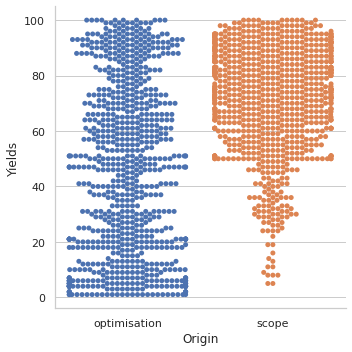

In [49]:
# Yield distribution according to scope/optimization
display_df =  pd.DataFrame(zip(y, mechanisms, origins), columns =['Yields', 'Mechanisms', 'Origin'])

sns.catplot(y="Yields", data=display_df, x='Origin',  kind="swarm")
plt.show()

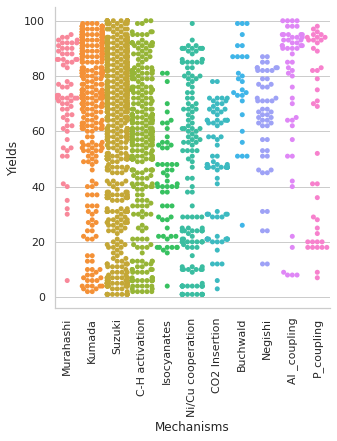

In [50]:
# Yield distribution according to mechanism
chart = sns.catplot(y="Yields", data=display_df, x='Mechanisms',  kind="swarm")
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.show()

In [73]:
def get_numerical_columns(X):
    indexes_columns = []
    for column in range(X.shape[1]):
        try:
            for row in range(X.shape[0]):   
                value = float(X[row, column])
            indexes_columns.append(column)
        except:
            pass
    return np.array(indexes_columns)
indexes_columns = get_numerical_columns(X)    
X_numerical = X[:, indexes_columns]
X_numerical = X_numerical.astype(np.float)

In [74]:
indexes_rows = np.isnan(X_numerical).any(axis=0)
indexes_rows = np.where(indexes_rows==False)[0]
X_numerical = X_numerical[:, indexes_rows]
#y = y[indexes_rows]
#DOIs = DOIs[indexes_rows]
#mechanisms = mechanisms[indexes_rows]
#origins = origins[indexes_rows]

In [75]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_numerical = scaler.fit_transform(X_numerical)

In [58]:
metric_values, baseline_values, sizes = analysis_train_set_size(X_numerical, y, DOIs, metric=metric, predictor=pipe, n_iterations_external=2, n_iterations_internal=1)

In [59]:
metric_mean = np.mean(metric_values, axis=1)
metric_lower = np.percentile(metric_values, 5, axis=1)
metric_upper = np.percentile(metric_values, 95, axis=1)

baseline_mean = np.mean(baseline_values, axis=1)
baseline_lower = np.percentile(baseline_values, 5, axis=1)
baseline_upper = np.percentile(baseline_values, 95, axis=1)

# 2. Evolution of performance with training data availibility

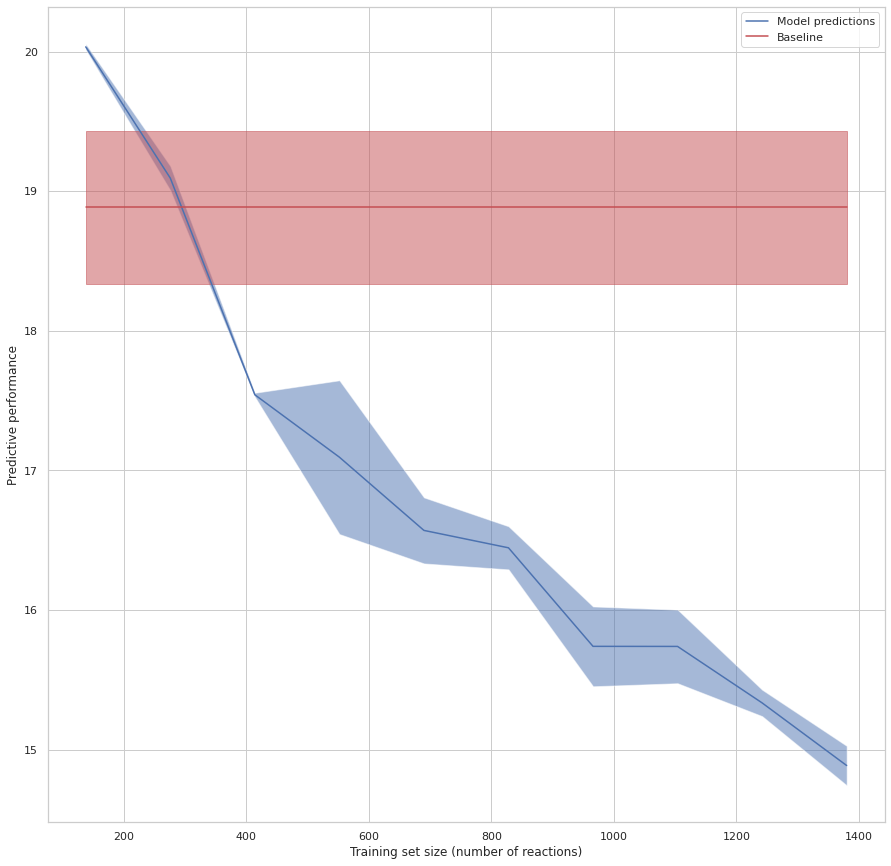

In [60]:
# How does (with fixed test set) performance improves as the training set size augments?
plt.figure(figsize=(15, 15))
plt.plot(sizes, metric_mean, label='Model predictions')
plt.fill_between(sizes, metric_lower, metric_upper, alpha=0.5)

plt.plot(sizes, baseline_mean, c='r', label='Baseline')
plt.fill_between(sizes, baseline_lower, baseline_upper, color='r', alpha=0.5)

plt.xlabel("Training set size (number of reactions)")
plt.ylabel("Predictive performance")

plt.legend()
plt.show()

In [76]:
metric_standalone, metric_augmented, metric_baseline_standalone, metric_baseline_augmented, unique_stratification, sizes = analysis_stratification_influence(X_numerical, y, DOIs, metric=metric, predictor = pipe, test_size=0.95, n_iterations=2)

In [77]:
metric_augmented = np.mean(metric_augmented, axis=1)
metric_standalone = np.mean(metric_standalone, axis=1)
metric_baseline_standalone = np.mean(metric_baseline_standalone, axis=1)


In [16]:
metric_mechanism, metric_augmented_mechanism, metric_baseline_mechanism, _, unique_stratification_mechanism, sizes_mechanism = analysis_stratification_influence(X, y, mechanisms, metric=metric, predictor = pipe, test_size=0.2, n_iterations=2)

In [17]:
metric_augmented_mechanism = np.mean(metric_augmented_mechanism, axis=1)
metric_mechanism = np.mean(metric_mechanism, axis=1)
metric_baseline_mechanism = np.mean(metric_baseline_mechanism, axis=1)

In [78]:
def doi_2_mechanism(DOIs, doi):
    dois_indexes = np.where(DOIs==doi)[0]
    mechanism = mechanisms[dois_indexes[0]]
    return mechanism

def doi_2_origin(DOIs, doi):
    dois_indexes = np.where(DOIs==doi)[0]
    origin = origins[dois_indexes[0]]
    return origin

mecha = [doi_2_mechanism(DOIs, x) for x in unique_stratification]
orig = [doi_2_origin(DOIs, x) for x in unique_stratification]

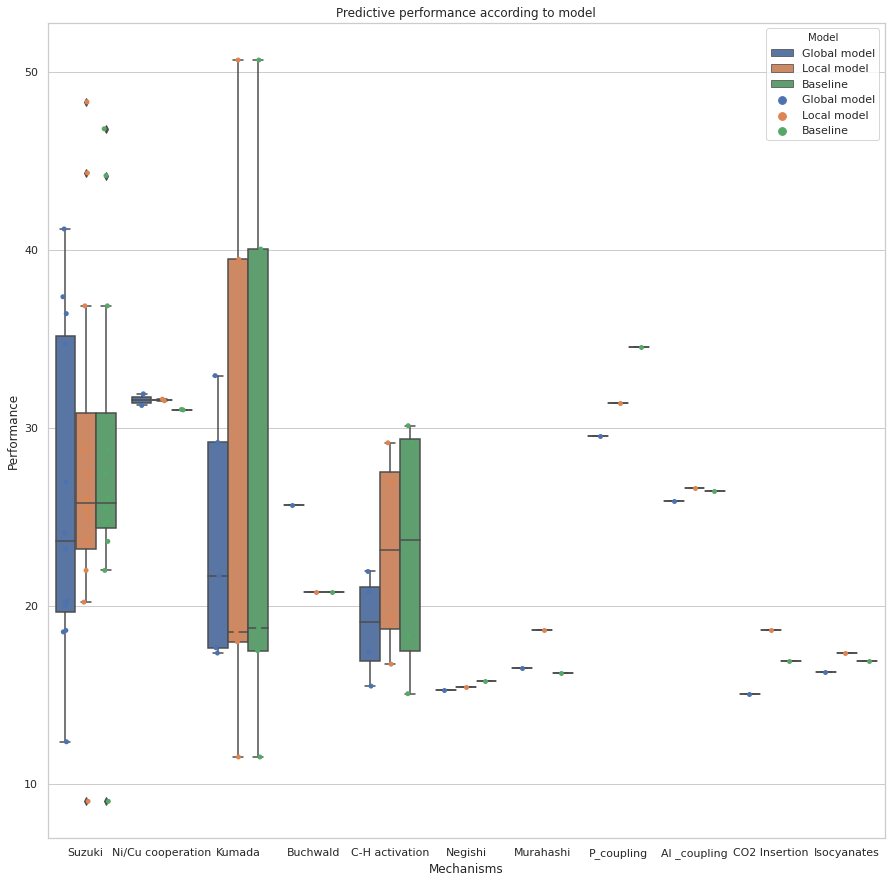

In [79]:
# Comparison of performance (distribution by DOI) of global, local and baseline models, stratified by mechanism

plt.figure(figsize=(15, 15))

global_df = pd.DataFrame(zip(metric_augmented, sizes, unique_stratification, mecha, orig, ["Global model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
local_df = pd.DataFrame(zip(metric_standalone, sizes, unique_stratification, mecha, orig, ["Local model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
baseline_df = pd.DataFrame(zip(metric_baseline_standalone, sizes, unique_stratification, mecha, orig, ["Baseline" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])

display_df = pd.concat([global_df, local_df, baseline_df])

plt.title("Predictive performance according to model")
#plt.ylim(-5, 5)
sns.stripplot(x = "Mechanisms", y="Performance",  data=display_df, hue="Model", dodge=True)
sns.boxplot(x = "Mechanisms", y="Performance",  data=display_df, hue="Model", dodge=True)

plt.show()

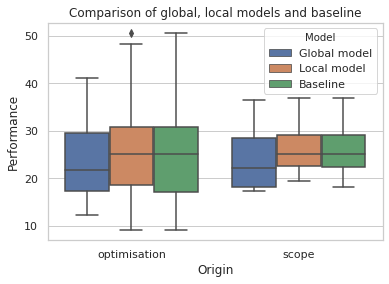

In [82]:
# Comparison of performance (distribution by DOI) of global, local and baseline models, stratified by scope/optimization

plt.title("Comparison of global, local models and baseline")
chart = sns.boxplot(x = "Origin", y="Performance",  data=display_df, hue="Model")

plt.show()

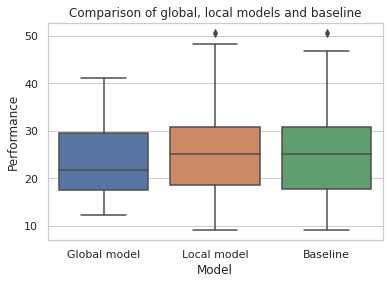

In [83]:
# Comparison of performance (distribution by mechanism) of global, local by mechanism and baseline models 

plt.title("Comparison of global, local models and baseline")
chart = sns.boxplot(x = 'Model', y="Performance",  data=display_df, dodge=True)
plt.show()

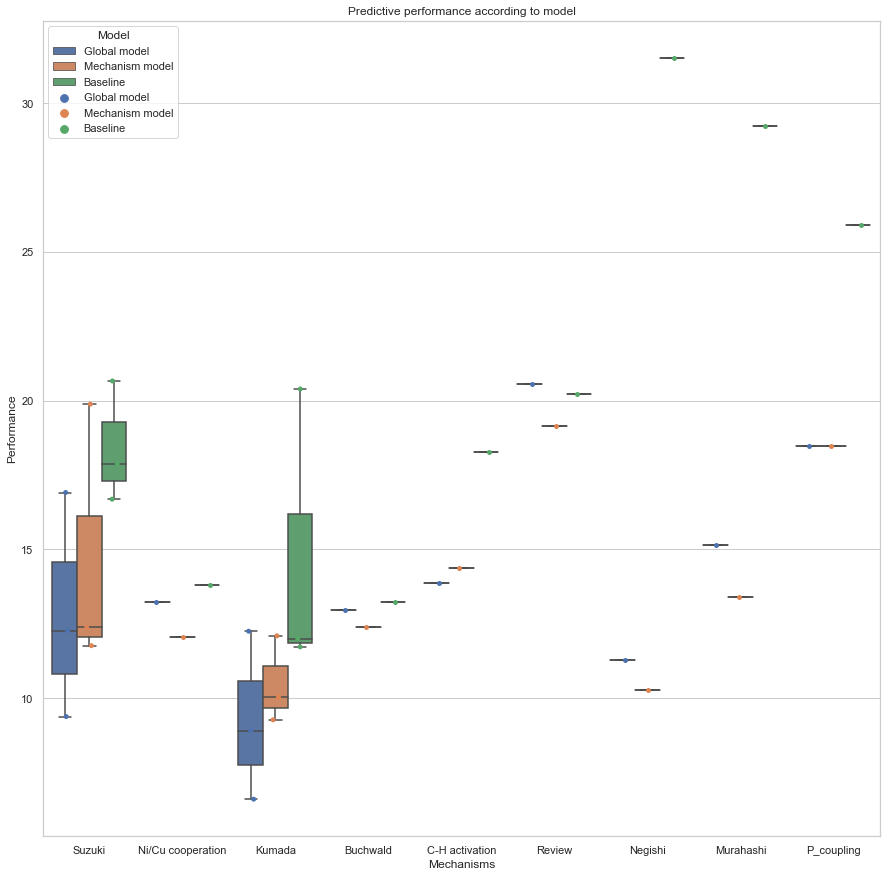

In [23]:
# Comparison of performance (distribution by mechanism) of global, local by mechanism and baseline models, stratified by mechanism

plt.figure(figsize=(15, 15))

global_df = pd.DataFrame(zip(metric_augmented_mechanism, sizes, unique_stratification, mecha, orig, ["Global model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
local_df = pd.DataFrame(zip(metric_mechanism, sizes, unique_stratification, mecha, orig, ["Mechanism model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
baseline_df = pd.DataFrame(zip(metric_baseline_mechanism, sizes, unique_stratification, mecha, orig, ["Baseline" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])

display_df = pd.concat([global_df, local_df, baseline_df])

plt.title("Predictive performance according to model")
#plt.ylim(-5, 5)
sns.stripplot(x = "Mechanisms", y="Performance",  data=display_df, hue="Model", dodge=True)
sns.boxplot(x = "Mechanisms", y="Performance",  data=display_df, hue="Model", dodge=True)

plt.show()

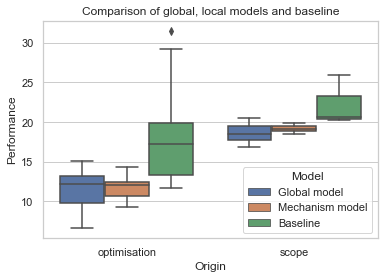

In [24]:
plt.title("Comparison of global, local models and baseline")
chart = sns.boxplot(x = "Origin", y="Performance",  data=display_df, hue="Model")

plt.show()

# 3. Increase of performance compared to baseline, by DOI

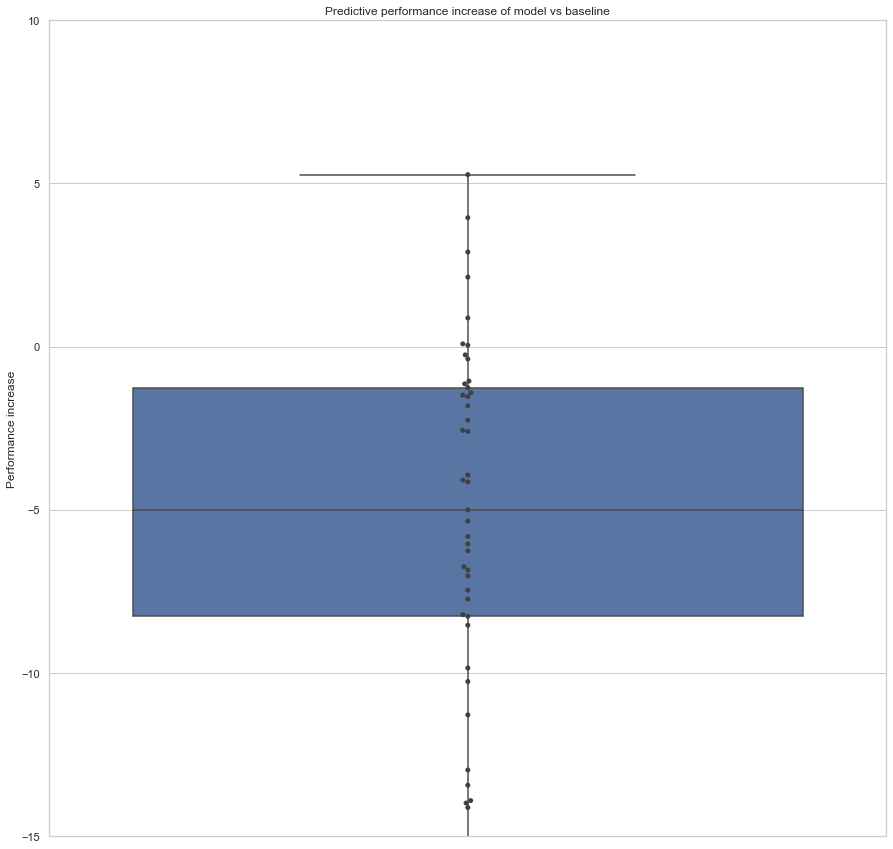

In [28]:
# Distribution of performance increase, global model vs baseline 
plt.figure(figsize=(15, 15))

display_df = pd.DataFrame(metric_augmented-metric_baseline_standalone, columns =['Performance increase'])

plt.title("Predictive performance increase of model vs baseline")
sns.boxplot(y="Performance increase", data=display_df)
sns.swarmplot(y="Performance increase", data=display_df, color=".25")
plt.ylim(-15, 10)
plt.show()

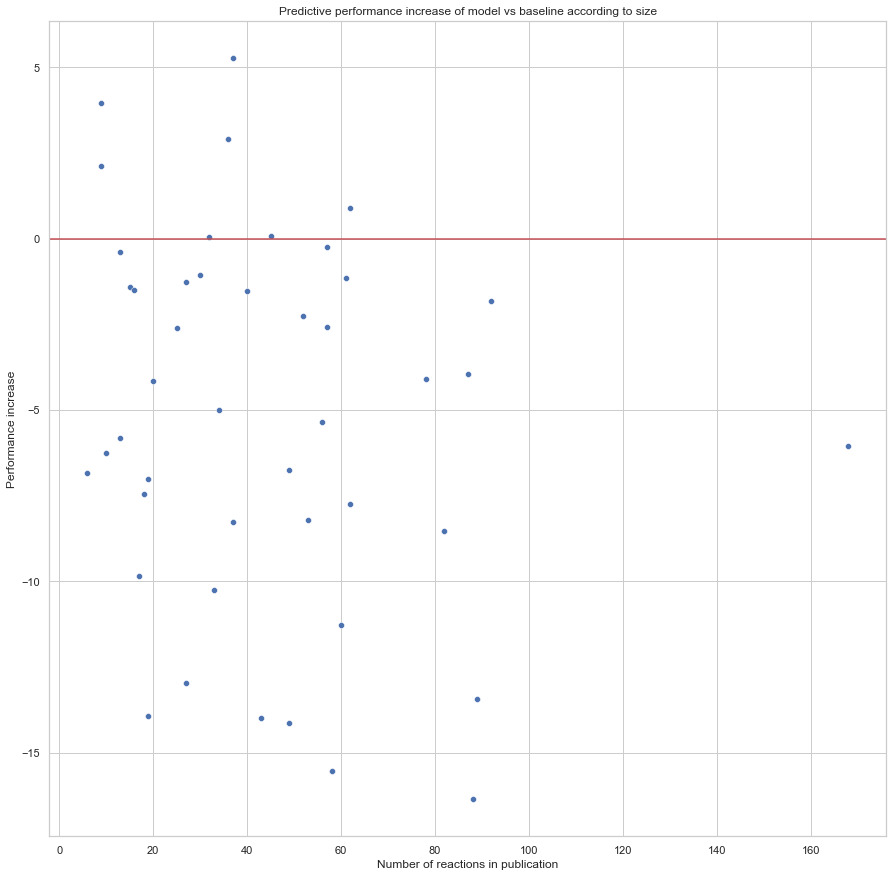

In [29]:
# Distribution of performance increase, global model vs baseline, by size of publication

plt.figure(figsize=(15, 15))

mecha = [doi_2_mechanism(DOIs, x) for x in unique_stratification]
orig = [doi_2_origin(DOIs, x) for x in unique_stratification]

display_df = pd.DataFrame(zip([x for x in metric_augmented-metric_baseline_standalone], sizes, unique_stratification, mecha, orig), columns =['Performance increase', "Size", "DOI", "Mechanisms", "Origin"])

plt.title("Predictive performance increase of model vs baseline according to size")
sns.scatterplot(x="Size", y="Performance increase", data=display_df)
plt.xlabel("Number of reactions in publication")
#plt.ylim(-1, 1.5)
plt.axhline(0, c='r')

plt.show()

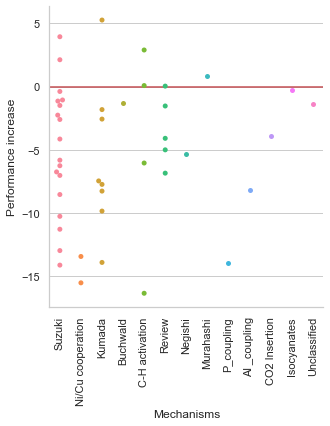

In [30]:
# Distribution of performance increase, global model vs baseline, by mechanism

chart = sns.catplot(x="Mechanisms", y="Performance increase", data=display_df, kind="swarm")
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.axhline(0, c='r')
plt.show()

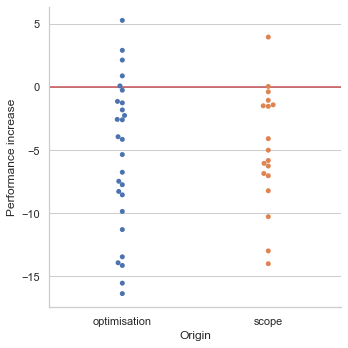

In [31]:
# Distribution of performance increase, global model vs baseline, by scope/optimization

chart = sns.catplot(x="Origin", y="Performance increase", data=display_df, kind="swarm")

plt.axhline(0, c='r')
plt.show()

# 4. Increase of performance compared to local model, by DOI

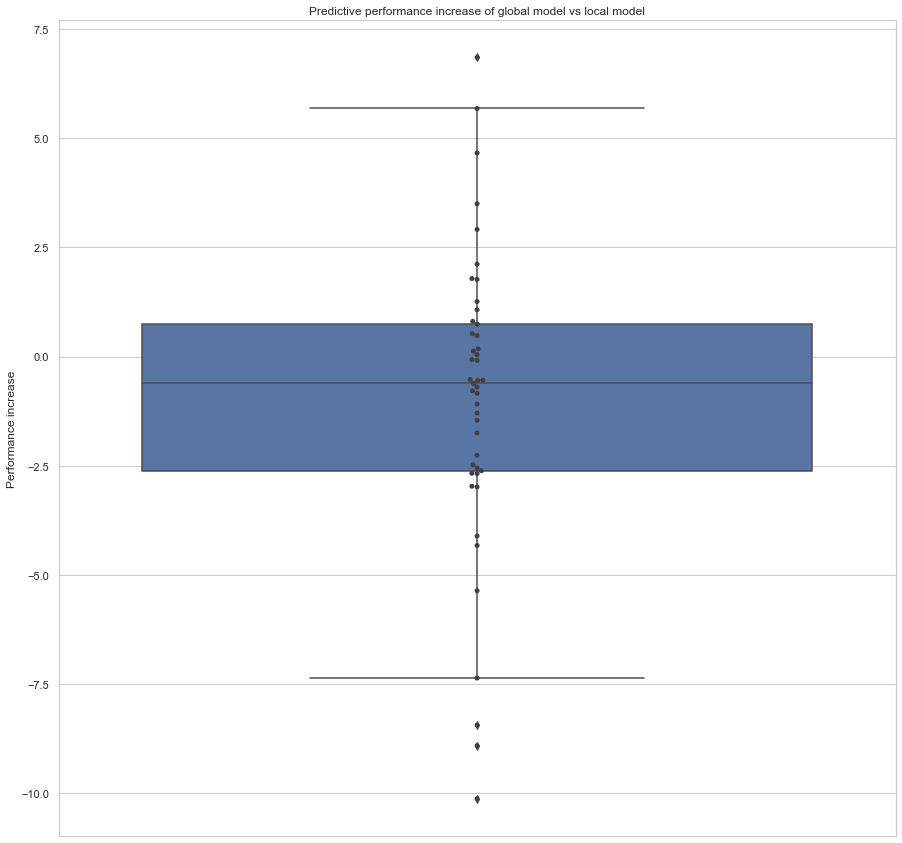

In [32]:
# Distribution of performance increase, global model vs local model

plt.figure(figsize=(15, 15))

display_df = pd.DataFrame(zip([x for x in metric_augmented-metric_standalone], sizes, unique_stratification, mecha, orig), columns =['Performance increase', "Size", "DOI", "Mechanisms", "Origin"])

plt.title("Predictive performance increase of global model vs local model")
sns.boxplot(y="Performance increase", data=display_df)
sns.swarmplot(y="Performance increase", data=display_df, color=".25")

plt.show()

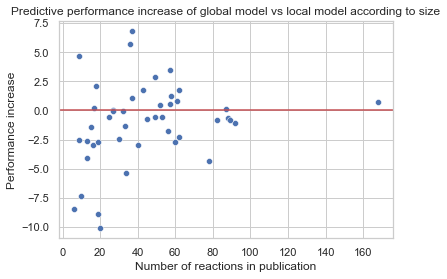

In [33]:
# Distribution of performance increase, global model vs local model, by size of publication

plt.title("Predictive performance increase of global model vs local model according to size")
sns.scatterplot(x="Size", y="Performance increase", data=display_df)
plt.xlabel("Number of reactions in publication")
#plt.ylim(-1, 1.5)
plt.axhline(0, c='r')

plt.show()

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


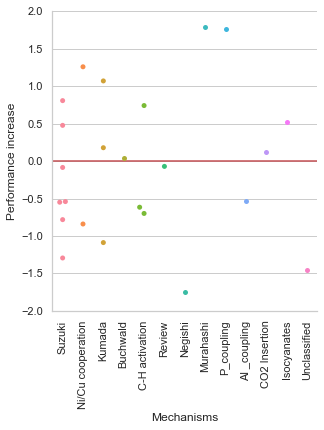

In [34]:
# Distribution of performance increase, global model vs local model, by mechanism

chart = sns.catplot(x="Mechanisms", y="Performance increase", data=display_df, kind="swarm")
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.axhline(0, c='r')
plt.ylim(-2, 2)
plt.show()

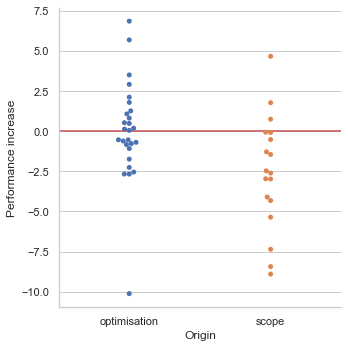

In [35]:
# Distribution of performance increase, global model vs local model, by scope/optimization

chart = sns.catplot(x="Origin", y="Performance increase", data=display_df, kind="swarm")
plt.axhline(0, c='r')
plt.show()